In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from functions import get_VaR

PATH_TO_DATA = "data/data_with_return.csv"
SEED = 404

In [2]:
df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16')
df.sample(5, random_state=SEED)

,TRADEDATE,SECID,NUMTRADES,LEGALCLOSEPRICE,CLOSE,VOLUME,TRENDCLSPR,RETURN
30125,2018-09-17,VZRZ,37,431.0000,431.00000,534,-1.15,-0.011534
10497,2018-04-04,TGKN,34,0.0053,0.00536,98000000,2.88,0.017127
8842,2018-03-21,MSST,50,1.1200,1.12000,24400,0.00,0.004474
24844,2018-08-02,MSRS,113,0.7260,0.72800,4320000,0.28,0.000000
38823,2018-11-29,RUGR,1754,6.2800,6.28000,590660,0.88,0.008797


In [3]:
VaR_9 = lambda x: get_VaR(x, 0.9)
VaR_95 = lambda x: get_VaR(x, 0.95)
df_with_VaR = df.groupby(by="SECID", as_index=False)\
                    .agg(
                        var_1=pd.NamedAgg(column="RETURN", aggfunc=VaR_9),
                        var_2=pd.NamedAgg(column="RETURN", aggfunc=VaR_95),
                    )\
                    .rename(columns={"var_1": "VaR (0.9)", "var_2": "VaR (0.95)"})

In [4]:
# Актив с самой большой потерей
max_VaR = df_with_VaR.sort_values(by="VaR (0.9)", ascending=False).head(1)
max_VaR_name = df_with_VaR.sort_values(by="VaR (0.9)", ascending=False).head(1).SECID.values[0]
max_VaR

,SECID,VaR (0.9),VaR (0.95)
130,SIBG,0.076145,0.109182


In [5]:
# Актив с наименьшей потерей
min_VaR = df_with_VaR.sort_values(by="VaR (0.9)").head(1)
min_VaR_name = df_with_VaR.sort_values(by="VaR (0.9)").head(1).SECID.values[0]
min_VaR

,SECID,VaR (0.9),VaR (0.95)
159,VSMO,0.006897,0.010238


/home/susbar/miniconda3/envs/hse_stocks/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


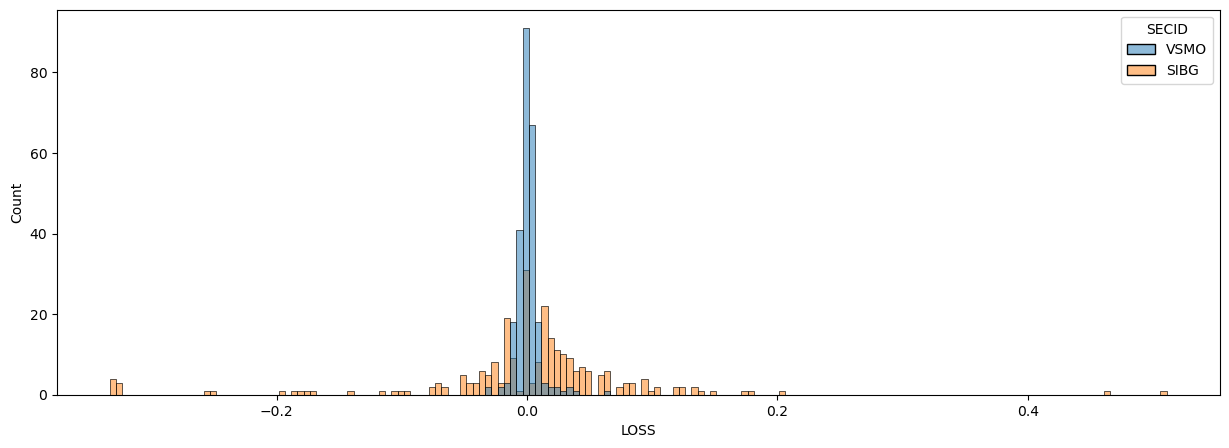

In [6]:
plt.figure(figsize=(15, 5))
df_loss = df[df.SECID.isin([max_VaR_name, min_VaR_name])]
df_loss = df_loss.assign(LOSS=-df_loss.RETURN)

sns.histplot(data=df_loss, x="LOSS", hue="SECID");

VaR портфеля с одинаковыми доля (γ = 0.90): 0.000013
VaR портфеля с одинаковыми доля (γ = 0.95): 0.000017


/home/susbar/miniconda3/envs/hse_stocks/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


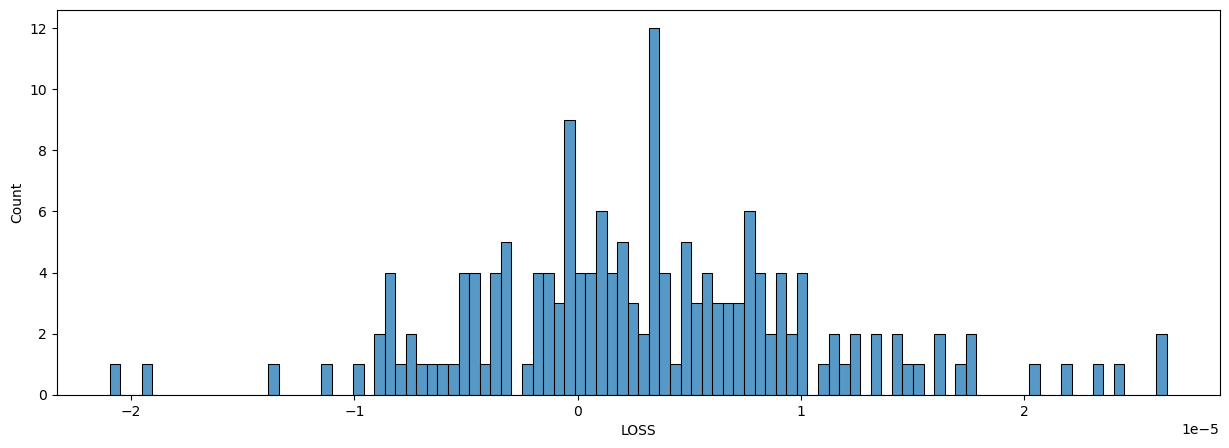

In [7]:
N = df.SECID.nunique()
equal_portfolio_returns = df.groupby(by="SECID", as_index=False).agg({"RETURN": "mean"}).RETURN / N
VaR_eq_p_9 = get_VaR(equal_portfolio_returns)
VaR_eq_p_95 = get_VaR(equal_portfolio_returns, gamma=0.95)
print(f"VaR портфеля с одинаковыми доля (γ = 0.90): {VaR_eq_p_9:.6f}")
print(f"VaR портфеля с одинаковыми доля (γ = 0.95): {VaR_eq_p_95:.6f}")

plt.figure(figsize=(15, 5))
ax = sns.histplot(x=-equal_portfolio_returns, bins=100);
ax.set(xlabel="LOSS")
plt.show()

In [8]:
stocks_statistics = pd.read_csv("data/stocks_statistics.csv", encoding='UTF-16', index_col=[0])

stocks_statistics.at[min_VaR_name, "type"] = "min_VaR"
stocks_statistics.at[max_VaR_name, "type"] = "max_VaR"

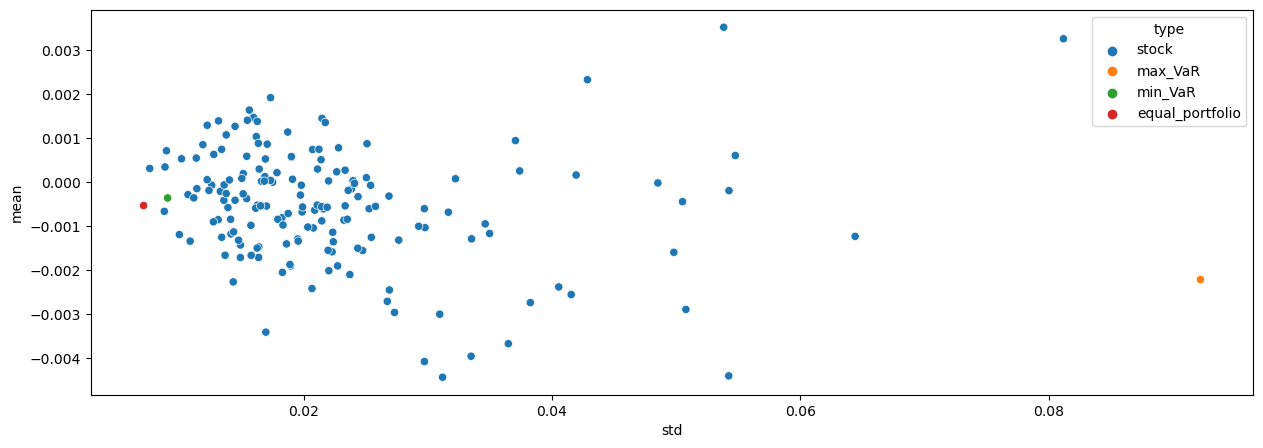

In [9]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=stocks_statistics, x="std", y="mean", hue="type");